In [ ]:
!pip install stable_baselines3
!pip install optuna
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2409499 sha256=7f22c67486a8941bdb4180a57753672faa67bfc6a2bf6d7555a8828280c3a5cb
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [ ]:
import gymnasium as gym

from stable_baselines3 import DQN
from stable_baselines3 import PPO

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
log_dir = "./logs/"

## Environment

In [ ]:
env = Monitor(gym.make("LunarLander-v3"), filename=log_dir + "monitor.csv")

Evalutate callback


In [ ]:
eval_callback = EvalCallback(
    env,
    best_model_save_path=log_dir,
    log_path=log_dir,
    eval_freq=10_000,          # evaluate every 10k steps
    deterministic=True,
    render=False
)

# NOT RELEVANT


In [ ]:
env = make_vec_env("LunarLander-v3", n_envs=1)
env_val = make_vec_env("LunarLander-v3", n_envs=1)

In [ ]:
eval_callback = EvalCallback(env_val,
                             eval_freq=25_000,
                             render=False,
                             deterministic=True,
                             n_eval_episodes=20)

## DQN Modell

In [ ]:
dqn_model = DQN(
    "MlpPolicy",
    env,
    learning_rate=5e-5,
    buffer_size=200_000,
    learning_starts=20_000,
    batch_size=64,
    gamma=0.99,
    train_freq=4,
    target_update_interval=1000,
    exploration_fraction=0.2,
    exploration_final_eps=0.05,
    policy_kwargs=dict(net_arch=[256, 256]),
    verbose=0,
    tensorboard_log="./tensorboard/",
)

In [ ]:
dqn_model.learn(total_timesteps=2_000_000, callback=eval_callback)

Eval num_timesteps=5288, episode_reward=-530.71 +/- 127.53
Episode length: 153.40 +/- 52.37
Eval num_timesteps=15288, episode_reward=-627.48 +/- 62.91
Episode length: 115.00 +/- 52.62
Eval num_timesteps=25288, episode_reward=-145.36 +/- 43.20
Episode length: 713.60 +/- 351.43
Eval num_timesteps=35288, episode_reward=-91.09 +/- 19.10
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=45288, episode_reward=-135.10 +/- 42.51
Episode length: 926.40 +/- 67.81
Eval num_timesteps=55288, episode_reward=-123.69 +/- 41.14
Episode length: 757.40 +/- 198.94
Eval num_timesteps=65288, episode_reward=-122.81 +/- 27.91
Episode length: 334.60 +/- 72.17
Eval num_timesteps=75288, episode_reward=-147.89 +/- 32.24
Episode length: 300.40 +/- 67.77
Eval num_timesteps=85288, episode_reward=-83.98 +/- 19.69
Episode length: 552.40 +/- 365.86
Eval num_timesteps=95288, episode_reward=-116.15 +/- 37.41
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=105288, episode_reward=-107.96 +/- 7.16
Episode length: 1000

In [ ]:
# Evaluate the trained mode

mean_reward, std_reward = evaluate_policy(dqn_model, env, n_eval_episodes=20)

print(f"Mean reward: {mean_reward} +/- {std_reward}")

dqn_model.save("dqn_lunar_lander_2")

Mean reward: 263.33771715 +/- 38.206357018073966


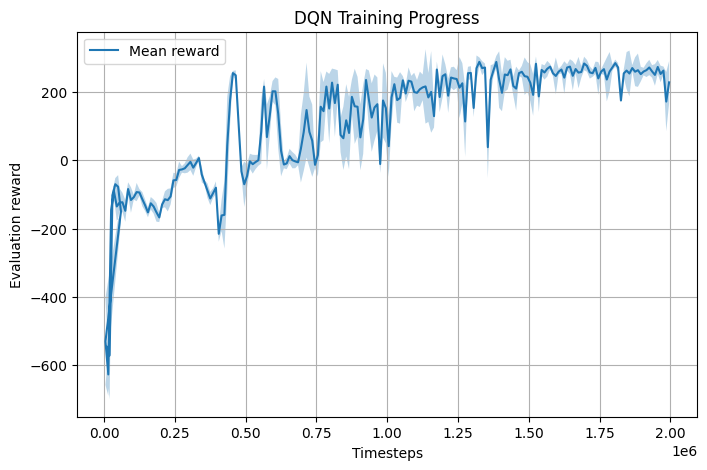

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load("./logs/evaluations.npz")
timesteps = data["timesteps"]
results = data["results"]

mean = results.mean(axis=1)
std = results.std(axis=1)

plt.figure(figsize=(8,5))
plt.plot(timesteps, mean, label="Mean reward")
plt.fill_between(timesteps, mean - std, mean + std, alpha=0.3)
plt.xlabel("Timesteps")
plt.ylabel("Evaluation reward")
plt.title("DQN Training Progress")
plt.legend()
plt.grid()
plt.show()


## PPO Modell

In [ ]:
log_dir = "./ppo_logs"
tensorboard_dir = "./ppo_tensorboard"

In [ ]:
ppo_env = DummyVecEnv([lambda: Monitor(gym.make("LunarLander-v3"))])
eval_env = DummyVecEnv([lambda: gym.make("LunarLander-v3")])

In [ ]:
eval_callback_ppo = EvalCallback(
    eval_env,
    best_model_save_path=log_dir,
    log_path=log_dir,
    eval_freq=10_000,         # evaluate every 10k steps
    deterministic=True,
    render=False
)

In [ ]:
ppo_model = PPO(
    "MlpPolicy",
    ppo_env,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
    vf_coef=0.5,
    max_grad_norm=0.5,
    verbose=0,
    tensorboard_log=tensorboard_dir
)

In [ ]:
ppo_model.learn(total_timesteps=2_000_000, callback=eval_callback_ppo)

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=10000, episode_reward=-451.83 +/- 51.04
Episode length: 100.20 +/- 24.52
New best mean reward!
Eval num_timesteps=20000, episode_reward=-1837.80 +/- 403.23
Episode length: 283.80 +/- 44.71
Eval num_timesteps=30000, episode_reward=-2557.35 +/- 109.84
Episode length: 343.00 +/- 32.74
Eval num_timesteps=40000, episode_reward=-591.25 +/- 165.52
Episode length: 382.60 +/- 64.74
Eval num_timesteps=50000, episode_reward=-594.10 +/- 118.81
Episode length: 436.60 +/- 60.80
Eval num_timesteps=60000, episode_reward=-251.68 +/- 21.37
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=70000, episode_reward=-186.27 +/- 23.04
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=80000, episode_reward=-13.05 +/- 17.42
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=90000, episode_reward=28.65 +/- 116.79
Episode length: 606.60 +/- 132.21
New best mean reward!
Eval num_timesteps=100000, episode_reward=213.15 +/- 16.8

In [ ]:
# Evaluate the trained mode

mean_reward, std_reward = evaluate_policy(ppo_model, ppo_env, n_eval_episodes=20)

print(f"Mean reward: {mean_reward} +/- {std_reward}")

ppo_model.save("ppo_lunar_lander")

Mean reward: 281.89231415000006 +/- 32.58030784277455


Visualize

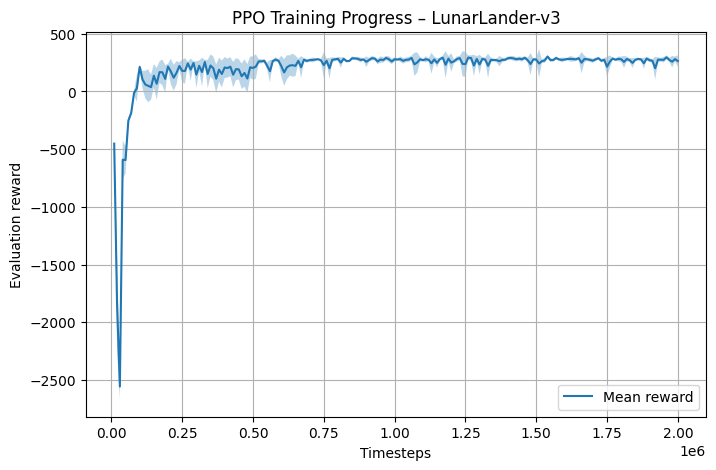

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load("./ppo_logs/evaluations.npz")
timesteps = data["timesteps"]
results = data["results"]
mean = results.mean(axis=1)
std = results.std(axis=1)

plt.figure(figsize=(8,5))
plt.plot(timesteps, mean, label="Mean reward")
plt.fill_between(timesteps, mean - std, mean + std, alpha=0.3)
plt.xlabel("Timesteps")
plt.ylabel("Evaluation reward")
plt.title("PPO Training Progress – LunarLander-v3")
plt.legend()
plt.grid()
plt.show()
